In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# wavenumber and wavelength
k = 2.0 * np.pi
lamb =  2.0 * np.pi / k

# domain [la,lb]
la = -8.0 * lamb
lb = 8.0 * lamb

# define the mesh for observation
N_obs = 240
h_obs = (lb - la) / N_obs
mesh_obs = np.linspace(la, lb, (N_obs + 1))

mesh_mid_obs = np.zeros(N_obs + 1)

mesh_mid_obs[0] = la

for od in range(N_obs):
    mesh_mid_obs[od + 1] = (mesh_obs[od] + mesh_obs[od+1])/2.0

# transform numpy mesh to torch mesh
x_mid_obs = torch.tensor(mesh_mid_obs, dtype = torch.float32, requires_grad = True)
x_mesh_obs = torch.tensor(mesh_obs, dtype = torch.float32, requires_grad = True)

# define the maximum number of testing points
N_inv = 480

# define the max and min of surface height
hmax = 0.2 * lamb
hmin = -0.2 * lamb

In [3]:
# angle of grazing
alpha = torch.tensor([[-1.0 * np.pi / 4.0]])

# the incident wave, which is a plane wave
def inc_field(x, z):
    g = torch.cos(alpha) * x + torch.sin(alpha) * z
    return torch.exp(1.0 * 1j * k * g)

# observation height 
zp = lamb * 0.4

# Hankel function of first order of first kind
def hankel(sth):
    return torch.special.bessel_j1(sth) + 1j * torch.special.bessel_y1(sth)

# method of moments
def MOM(x_mid, hei_vec, heid_vec, heidd_vec):
    ''' This function implements the method of moments.
     x_mid is the mesh points.
     hei_vec is the torch tensor for the surface height.
     heid_vec is the torch tensor of the derivative of surface height.
     heidd_vec is the torch tensor of the second order derivative of surface height.
     it reaturns the torch tensor of scattered field.'''
    
    h = x_mid[100] - x_mid[99]
    N = x_mid.numel() - 1
    
    # aseemble surface incident field
    inc_vec =  torch.zeros(N, dtype=torch.cfloat)
    for i in range(N):
        inc_vec[i] = inc_field(x_mid[i+1], hei_vec[i+1])
        
    # aseemble matrix A
    A =  torch.zeros((N, N), dtype=torch.cfloat)
    
    # off-diagonal terms
    def getA_offdiag1(nn):
        ll = torch.arange(1, nn)
        ptl = torch.sqrt((x_mid[nn] - x_mid[ll]) ** 2 + (hei_vec[nn] - hei_vec[ll])**2)
        inte1 = hankel(k * ptl) / ptl
        inte2 = -1.0 * heid_vec[ll] * (x_mid[nn] - x_mid[ll]) + (hei_vec[nn] - hei_vec[ll])
        sd = torch.sqrt(1.0 + heid_vec[ll] ** 2)
        return 1.0 * k * 1j / 4.0 * h * inte1 * inte2 * sd 
    def getA_offdiag2(nn):
        ll = torch.arange(nn + 1, N + 1)
        ptl = torch.sqrt((x_mid[nn] - x_mid[ll]) ** 2 + (hei_vec[nn] - hei_vec[ll])**2)
        inte1 = hankel(k * ptl) / ptl
        inte2 = -1.0 * heid_vec[ll] * (x_mid[nn] - x_mid[ll]) + (hei_vec[nn] - hei_vec[ll])
        sd = torch.sqrt(1.0 + heid_vec[ll] ** 2)
        return 1.0 * k * 1j / 4.0 * h * inte1 * inte2 * sd 
    
    # diagonal terms
    def getA_diag(nn):
        return 1.0 * h * k * heidd_vec[nn] / ((1.0 + heid_vec[nn] ** 2) * 4 * torch.pi)

    for nu in range(N):
        A[nu, 0:nu] = -1.0 * getA_offdiag1(nu + 1)
        A[nu, nu+1:N] = -1.0 * getA_offdiag2(nu + 1)
        A[nu, nu] = -1.0 * getA_diag(nu + 1) + torch.tensor([0.5])
    
    # solve for surface current
    phid = torch.linalg.solve(A, inc_vec)
    
    zz = torch.tensor([zp])
    
    # assemble matrix B
    B =  torch.zeros((N, N), dtype=torch.cfloat)

    # components of matrix B
    def getB(nn):
        rr = torch.arange(1, N + 1)
        ptl = torch.sqrt((x_mid[nn] - x_mid[rr]) ** 2 + (zz - hei_vec[rr])**2)
        inte1 = hankel(k * ptl) / ptl
        inte2 = -1.0 * heid_vec[rr] * (x_mid[nn] - x_mid[rr]) + (zz - hei_vec[rr])
        sd = torch.sqrt(1.0 + heid_vec[rr] ** 2)
        return 1.0 * k * h * 1j / 4.0 * inte1 * inte2 * sd 
    
    for nd in range(N):
        B[nd, 0:N] = getB(nd + 1)

    # calculate scattered field
    phis = torch.matmul(B, phid)
    
    return phis

In [4]:
# load the data of actual surface 
hei_actual_torch = torch.load('./vector_true_surface.pt')

# load the data list of the interpolated scattered field
# data without noise
data_phis_without_noise = torch.load('./data_scattered_field_without_noise.pt')
# data with noise
data_phis_with_noise = torch.load('data_scattered_field_with_noise.pt')

In [5]:
# main structure for the neural network

class Net(nn.Module):
    # NL: the number of hidden layers
    # NN: the number of vertices in each layer
    def __init__(self, NL, NN):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(1, NN)

        self.hidden_layers = nn.ModuleList([nn.Linear(NN, NN) for i in range(NL)])

        self.output_layer = nn.Linear(NN, 1)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)

In [6]:
# define MSE loss for complex-valued tensors

def complex_mse_loss(input_tensor, target_tensor):
    
    # Split input and target tensors into real and imaginary parts
    input_real, input_imag = input_tensor.real, input_tensor.imag
    target_real, target_imag = target_tensor.real, target_tensor.imag

    # Calculate squared error for real and imaginary components separately
    real_mse_loss = torch.mean((input_real - target_real) ** 2)
    imag_mse_loss = torch.mean((input_imag - target_imag) ** 2)

    # Combine the real and imaginary losses
    mse_loss = real_mse_loss + imag_mse_loss

    return mse_loss

# at each epoch, we generate a mesh of size N_t, N_t is inside [N_obs, N_inv]
def generate_mesh():
    
    # first generate a random number N_t
    N_t = torch.randint(N_obs, N_inv + 1, (1,)).item()
    
    # identify the position in the data list
    idx = N_t - N_obs
    
    # generate the mesh
    x_mesh = torch.linspace(la,lb, N_t+1, requires_grad = True).view(-1,1)
    x_train = torch.zeros(N_t + 1)
    x_train[0] = la
    for od in range(N_t):
        x_train[od + 1] = (x_mesh[od] + x_mesh[od+1])/2.0
        
    return idx, x_train, N_t
    
# normalization of a tensor
def normalize_tensor(input_tensor):
    
    min_val = input_tensor.min()
    max_val = input_tensor.max()
    normalized_tensor = 2 * (input_tensor - min_val) / (max_val - min_val) - 1
    
    return normalized_tensor

# the inverse normalization of a tensor
def inverse_normalize_tensor(normalized_tensor, original_max, original_min):
    
    # Compute the scale and shift parameters
    scale = (original_max - original_min) / 2
    shift = (original_max + original_min) / 2
    
    inverse_normalized_tensor = normalized_tensor * scale + shift
    return inverse_normalized_tensor

# the automatic differentiation gives the first order derivative of normalization of output
# w.r.t. normalizaton of input, applying the chain rule function leads to the
# actual first order derivative of target output w.r.t. target input
def chain_rule_first_order(first_order_derivative_tensor, output_max, output_min, input_max, input_min):
    return (output_max - output_min) * first_order_derivative_tensor / (input_max - input_min)

# the automatic differentiation gives the second order derivative of normalization of output
# w.r.t. normalizaton of input, applying this chain rule function leads to the
# actual second order derivative of target output w.r.t. target input
def chain_rule_second_order(second_order_derivative_tensor, output_max, output_min, input_max, input_min):
    return 2.0 * (output_max - output_min) * second_order_derivative_tensor / ((input_max - input_min) ** 2)

In [7]:
# set up parameters for PINN neural networks
# NL is number of hidden layers and NN is the number of neurons per hidden layer
net = Net(NL=4, NN=256)
# choose an optimizer and learning rate
optimizer = optim.Adam(net.parameters(), lr = 1E-3)
# set number of iterations
N_PINN = 2000

# this is the main loop for the PINN
for t in range(N_PINN):
    
    # first step, generate N_t and the mesh
    idx, x_train_ori, N_t = generate_mesh()
    
    # normalization of points
    x_train = normalize_tensor(x_train_ori)
    
    # forward propagation
    x_train = x_train.view(-1,1)
    y = net(x_train)
    
    # use automatic differentiation to find derivatives
    dy = torch.autograd.grad(y, x_train, grad_outputs= torch.ones(y.size()), create_graph = True)[0] 
    ddy = torch.autograd.grad(dy, x_train, grad_outputs= torch.ones(y.size()), create_graph = True)[0] 
    
    # transform the surface to 1D vector and apply inverse normalization
    hei_pred_net = y.view(-1)
    hei_pred = inverse_normalize_tensor(hei_pred_net, hmax, hmin)
    
    # transform first order derivative to 1D vector and apply the chain rule
    heid_pred_net = dy.view(-1)
    heid_pred = chain_rule_first_order(heid_pred_net, hmax, hmin, x_train_ori.max(), x_train_ori.min())
    
    # transform second order derivative to 1D vector and apply the chain rule
    heidd_pred_net = ddy.view(-1)
    heidd_pred = chain_rule_second_order(heidd_pred_net, hmax, hmin, x_train_ori.max(), x_train_ori.min())

    # use MOM to calculate the scattered field
    phis_pred = MOM(x_train_ori, hei_pred, heid_pred, heidd_pred)
    
    # identify the corresponding observed scattered data
    phis_obs = data_phis_with_noise[idx]
    
    # MSE loss of the residual of equation
    loss_eqn = complex_mse_loss(phis_pred, phis_obs)
    
    # find the predicted surface values on the close-boundary points
    indices_bc = torch.tensor([0, 1, 2, 3, 4, N_t, N_t - 1, N_t - 2, N_t - 3, N_t - 4])
    pred_bc = hei_pred[indices_bc]
    
    # MSE loss of boundary values
    loss_bc = torch.nn.MSELoss()(pred_bc, torch.zeros(10))
    
    # the total loss is the combination 
    loss = loss_eqn + loss_bc 
    
    # optimizing step with backward propagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
#     print(f"Epoch {t}, Loss: {loss.item()}")
    if (t + 1) % 100 == 0:
        print(f"Epoch {t + 1}, Loss: {loss.item()}")
        


Epoch 100, Loss: 0.36555665731430054
Epoch 200, Loss: 0.11912699043750763
Epoch 300, Loss: 0.12275735288858414
Epoch 400, Loss: 0.10736289620399475
Epoch 500, Loss: 0.11402914673089981
Epoch 600, Loss: 0.12211522459983826
Epoch 700, Loss: 0.10743960738182068
Epoch 800, Loss: 0.05215129628777504
Epoch 900, Loss: 0.03994646668434143
Epoch 1000, Loss: 0.010877731256186962
Epoch 1100, Loss: 0.006823730655014515
Epoch 1200, Loss: 0.008151018992066383
Epoch 1300, Loss: 0.003544025821611285
Epoch 1400, Loss: 0.0036626174114644527
Epoch 1500, Loss: 0.003784620901569724
Epoch 1600, Loss: 0.004100142512470484
Epoch 1700, Loss: 0.00413878308609128
Epoch 1800, Loss: 0.002369258087128401
Epoch 1900, Loss: 0.003138340311124921
Epoch 2000, Loss: 0.0028420768212527037


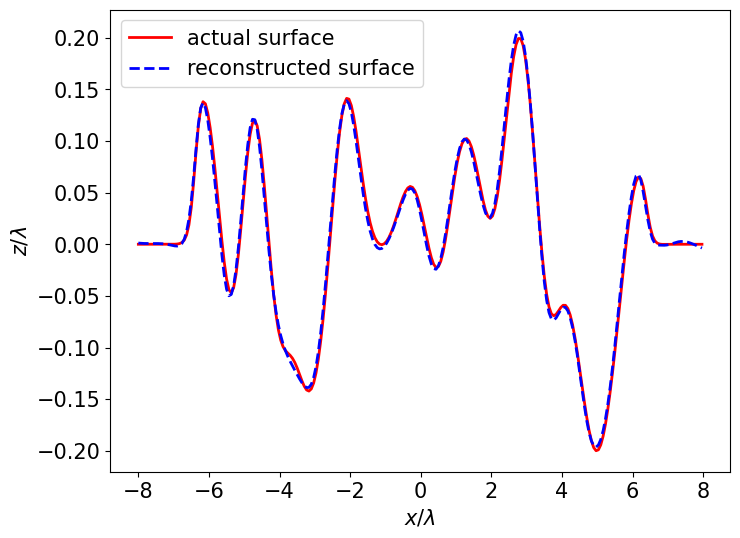

In [8]:
# normalization of testing points
x_mesh_test = normalize_tensor(x_mesh_obs)

# forward propagation and inverse normalization to obtain the result surface height
y = net(x_mesh_test.view(-1,1)).view(-1)
hei_pred_output = inverse_normalize_tensor(y, hmax, hmin)

# transform torch tensors to numpy arrays
hei_actual_vec = hei_actual_torch.detach().numpy()
hei_pred_vec = hei_pred_output.detach().numpy()

# plot the result
plt.figure(figsize=[8, 6])
line1, = plt.plot(mesh_mid_obs / lamb, hei_actual_vec / lamb, color='r', linewidth = 2)
line2, = plt.plot(mesh_mid_obs / lamb, hei_pred_vec / lamb, color='b', linewidth=2, linestyle = '--', fillstyle = 'none')
plt.xlabel(r'$x/{\lambda}$', fontsize = 15)
plt.ylabel(r'$z/{\lambda}$', fontsize = 15)
leg=plt.legend([line1, line2],
        ['actual surface',
        'reconstructed surface'],
        prop={'size': 15}, loc = "best")
plt.gca().tick_params(labelsize=15)
plt.show()

In [9]:
# calculate the l2 norm error
error_vec = hei_actual_vec - hei_pred_vec
print("l2 norm error is: ", np.linalg.norm(error_vec) / np.linalg.norm(hei_actual_vec))

l2 norm error is:  0.06567121
